In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'
import seaborn as sn
import numpy as np
import cv2 as cv
import os
from pathlib import Path
import classifier
import pandas as pd
import dataset.assemble as assemble
from dataset.transform import load_and_znorm, aug_hflip, apply_all_transforms
import plot_utils as plot
from itertools import chain
from functools import reduce
from operator import itemgetter
from tqdm import tqdm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Using TensorFlow backend.


In [3]:
def get_labels_from_generator(generator):
    generator.reset()
    _, y = next(generator)
    labels = y
    while generator.batch_index != 0:
        _, y = next(generator)
        labels = np.hstack((labels, y))
    return np.where(labels < 0.5, 'crystal', 'empty')
    
def get_predictions(test_generator):
    test_generator.reset()
    y_prob = model.predict_generator(test_generator, verbose=1).flatten()
    labels = np.where(y_prob < 0.5, 'crystal', 'empty')
    img, _ = test_generator.next()
    images = img
    while test_generator.batch_index != 0:
        img, _ = next(test_generator)
        images = np.hstack((images, img))
    idx = 0
    images, labels = np.array(images), np.array(labels)
    for i in range(idx, len(labels), batch_size):
        yield images[idx:idx+batch_size], labels[idx:idx+batch_size]
        idx += batch_size
        
def split_by_group(df, labels):
    from sklearn.model_selection import train_test_split
    train_df, validation_df, test_df = [pd.DataFrame()] * 3
    for label in labels:
        groups = set(df[df['label'] == label]['group'])
        train, rest = train_test_split(list(groups), test_size=0.4, random_state=42)
        validation, test = train_test_split(rest, test_size=0.5, random_state=42)
        train_df = pd.concat([train_df, df[df['group'].isin(train)]])
        validation_df = pd.concat([validation_df, df[df['group'].isin(validation)]])
        test_df = pd.concat([test_df, df[df['group'].isin(test)]])
    return dict(train=train_df, validation=validation_df, test=test_df)

def split_by_index(df, **kwargs):
    from sklearn.model_selection import train_test_split
    index = df.index
    train, rest = train_test_split(index, test_size=0.4, random_state=42)
    validation, test = train_test_split(rest, test_size=0.5, random_state=42)
    return dict(train=df.loc[train], validation=df.loc[validation], test=df.loc[test])

def get_group_labels():
    import json
    from collections import defaultdict
    with open('/data/staff/common/ML-crystals/classification/labels.json', 'r') as f:
        labels = json.load(f)
    group_labels = defaultdict(list)
    [group_labels[v].append(k) for k, v in labels.items()]
    return group_labels
    
def group(df, **kwargs):
    return df.assign(group=df['sample'] + '_' + df['scan'])

def filter_labels(df, **kwargs):
    drop_labels = kwargs['filter_labels']
    drop_indices = df[df['label'].isin(drop_labels)].index
    df = df.drop(drop_indices)
    return df

def filter_groups(df, **kwargs):
    group_labels = kwargs['group_labels']
    drop_indices = df[df['group'].isin(group_labels['bad'])].index
    df = df.drop(drop_indices)
    return df

def filter_low_zoom(df, **kwargs):
    return df.drop(df[df['zoom'] < 4].index)

def keep_every_nth(df, **kwargs):
    d = kwargs['keep_every_nth']
    indices = pd.Int64Index([])
    if 'empty' in d:
        indices = indices.append(df[df['label'] == 'empty'].index[::d['empty']])
    if 'crystal' in d:
        indices = indices.append(df[df['label'] == 'crystal'].index[::d['crystal']])
    return df.loc[indices]

def augment_empty(df, **kwargs):
    pass
    
def label(df, **kwargs):
    group_labels = kwargs['group_labels']
    s = pd.Series(name='label', index=df.index)
    empty_idx = df[df['group'].isin(group_labels['empty'])].index
    crystal_idx = df[df['group'].isin(group_labels['crystal'])].index
    bad_idx = df[df['group'].isin(group_labels['bad'])].index
    s.loc[empty_idx] = 'empty'
    s.loc[crystal_idx] = 'crystal'
    s.loc[bad_idx] = 'bad'
    return pd.concat((df, s), axis=1)

def load_imgs(df, **kwargs):
    copy = df.copy()
    imgs = []
    with tqdm(total=len(df)) as pbar:
        for i, fp in enumerate(df['filename']):
            imgs.append(cv.imread(fp, cv.IMREAD_GRAYSCALE))
            pbar.update(1)
    copy['img'] = imgs
    return copy

def crop_imgs(df, **kwargs):
    copy = df.copy()
    h, w = df['img'].iloc[0].shape
    padding = (w - h) // 2
    if padding == 0:
        return copy
    copy['img'] = df['img'].map(lambda img: img[:, padding:-padding])
    return copy

def resize_imgs(df, **kwargs):
    copy = df.copy()
    shape = kwargs['input_shape']
    copy['img'] = df['img'].map(lambda img: cv.resize(img, shape[:2]))
    return copy

def balance_classes(df, **kwargs):
    nbr_empty = len(df[df['label'] == 'empty'])
    crystal_groups = df[df['label'] == 'crystal']['group'].values
    np.random.shuffle(crystal_groups)
    crystal_indices_keep = pd.Int64Index([])
    group_idx = 0
    while(len(crystal_indices_keep) < nbr_empty):
        tmp = df[df['group'] == crystal_groups[group_idx]].index
        crystal_indices_keep = crystal_indices_keep.append(tmp)
        group_idx += 1
    indices_keep = pd.Int64Index(crystal_indices_keep.append(df[df['label'] == 'empty'].index))
    return df.loc[indices_keep.values]

def create_dirs(dst):
    p = Path(dst)
    outer = ['train', 'validation', 'test']
    inner = ['crystal', 'empty']
    [(p / o / i).mkdir(exist_ok=False, parents=True) for i in inner for o in outer]
    
def read_images(src, shape):
    return np.array([read_image(fp, shape) for fp in Path(src).absolute().iterdir()])

def read_image(src, shape):
    mode = cv.IMREAD_COLOR if shape[-1] == 3 else cv.IMREAD_GRAYSCALE
    img = cv.imread(str(src), mode)
    shape = shape[:2]
    return cv.resize(img, shape)

def write_images(df, dst):
    from PIL import Image
    mode = 'L' if INPUT_SHAPE[-1] == 1 else 'RGB'
    n_fill = len(str(len(df)))
    for i, (_, row) in enumerate(df.iterrows()):
        Image.fromarray(row['img'], mode=mode).save(f"{DATA_DIR}/{dst}/{row['label']}/{str(i).zfill(n_fill)}.jpeg")
                                                    
def copy_images(df, dst):
    import shutil
    n_fill = len(str(len(df)))
    for i, (_, row) in enumerate(df.iterrows()):
        shutil.copy(row['filename'], f"{DATA_DIR}/{dst}/{row['label']}/{str(i).zfill(n_fill)}.jpeg")

def compose(*functions, **kwargs):
    def fg(f, g):
        print(g.__name__)
        return lambda x: f(g(x, **kwargs))
    return reduce(lambda f, g: lambda x: f(g(x, **kwargs)), functions, lambda x: x)
                    
def count_files(dir_):
    count = 0
    for root, dirs, files in os.walk(dir_):
        count += len(files)
    return count

In [6]:
DATA_DIR = Path('/data/staff/common/ML-crystals/classification/data2')
INPUT_SHAPE = (256, 256, 1)
df = assemble.get_dataset_df('/data/staff/common/ML-crystals/csv/classification.csv', has_meta=True)
kwargs = {
   'group_labels':get_group_labels(),
    'input_shape': INPUT_SHAPE,
    'keep_every_nth': {'empty': 10, 'crystal': 2},
    'filter_labels': ['bad', 'empty']
}
df = compose(resize_imgs, crop_imgs, load_imgs, keep_every_nth, filter_groups, filter_labels, label, group, filter_low_zoom, **kwargs)(df)
df_empty = pd.read_csv('/data/staff/common/ML-crystals/csv/empty_augmented.csv')
df_empty = keep_every_nth(compose(load_imgs, **kwargs)(df_empty).assign(label='empty'), **{'keep_every_nth': {'empty': 3}})
df_crystal = df[['group', 'filename', 'img']].assign(label='crystal')
df = pd.concat([df_crystal, df_empty], ignore_index=True)
print(f"Empty: {len(df[df['label'] == 'empty'])}\tCrystal: {len(df[df['label'] == 'crystal'])}")
df = compose(balance_classes, **kwargs)(df)
dataset_dict = split_by_group(df, ['empty', 'crystal'])
train_df, validation_df, test_df = itemgetter('train', 'validation', 'test')(dataset_dict)
df.head()

loading meta files
meta loaded


100%|██████████| 6660/6660 [00:02<00:00, 2476.09it/s]


Empty: 2220	Crystal: 3974


,group,filename,img,label
674,Sample-3-10_20180479_1,/data/visitors/biomax/20180479/20181214/raw/Sa...,"[[6, 8, 9, 6, 5, 8, 9, 7, 5, 7, 6, 5, 7, 8, 6,...",crystal
675,Sample-3-10_20180479_1,/data/visitors/biomax/20180479/20181214/raw/Sa...,"[[7, 7, 5, 8, 7, 9, 6, 7, 6, 7, 8, 6, 7, 7, 8,...",crystal
676,Sample-3-10_20180479_1,/data/visitors/biomax/20180479/20181214/raw/Sa...,"[[10, 8, 5, 5, 6, 6, 6, 8, 7, 7, 8, 5, 6, 6, 6...",crystal
677,Sample-3-10_20180479_1,/data/visitors/biomax/20180479/20181214/raw/Sa...,"[[5, 6, 6, 6, 6, 6, 7, 4, 6, 6, 5, 6, 5, 9, 5,...",crystal
678,Sample-3-10_20180479_1,/data/visitors/biomax/20180479/20181214/raw/Sa...,"[[7, 7, 6, 7, 7, 6, 7, 7, 4, 6, 8, 8, 7, 5, 5,...",crystal


In [20]:
try:
    create_dirs(DATA_DIR)
except FileExistsError as e:
    from shutil import rmtree
    rmtree(DATA_DIR)
    DATA_DIR.mkdir()
    create_dirs(DATA_DIR)
    
[write_images(df, dst) for dst, df in dataset_dict.items()];

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils import multi_gpu_model
from keras import optimizers
from keras.callbacks import EarlyStopping

img_width, img_height = INPUT_SHAPE[:2]
batch_size = 64
nbr_train = count_files(DATA_DIR / 'train')
nbr_validation = count_files(DATA_DIR / 'validation')
nbr_test = count_files(DATA_DIR / 'test')
epochs = 10
INPUT_SHAPE = (256, 256, 1)

def cats_dogs_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    parallel_model = multi_gpu_model(model, gpus=4)
    parallel_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=0.00001),
                  metrics=['accuracy'])
    return parallel_model


def data_generators(input_shape: tuple, batch_size: int, gen_config: dict = None, flow_config: dict = None):
    from keras.preprocessing.image import ImageDataGenerator
    if gen_config is None:
        gen_config = {}
    if flow_config is None:
        flow_config = {}
        
    gen_params = {'train':{}, 'test':{}, 'validation': {}}
    gen_params.update(gen_config)
    flow_params = {'train':{}, 'test':{}, 'validation': {}}
    flow_params.update(flow_config)
    
    width, height, channels = input_shape
    color_mode = 'grayscale' if channels == 1 else 'rgb'
    
    train_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['train'])
    validation_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['validation'])
    test_datagen = ImageDataGenerator(rescale=1. / 255, **gen_params['test'])
    
    datagens = {'train': train_datagen, 'validation': validation_datagen, 'test': test_datagen}
    
    generators = {}
    for key in gen_params.keys():
        print(f'{key}: ', end='')
        gen = datagens[key].flow_from_directory(
            f'{DATA_DIR}/{key}',
            color_mode=color_mode,
            target_size=(width, height),
            batch_size=batch_size,
            class_mode='binary', **flow_params[key])
        generators[key] = gen
        
    return generators

gen_d = {'brightness_range': (1.0, 1.3), 'horizontal_flip': True, 'rotation_range': 45}
generators = data_generators(INPUT_SHAPE, batch_size, gen_config={'train': gen_d}, flow_config={'test':{'shuffle':False}})
train_generator, validation_generator, test_generator = itemgetter('train', 'validation', 'test')(generators)

train: Found 2655 images belonging to 2 classes.
test: Found 844 images belonging to 2 classes.
validation: Found 969 images belonging to 2 classes.


In [151]:
# model = classifier.build_model2(INPUT_SHAPE)
model = cats_dogs_model()
early_stopping = EarlyStopping(monitor='loss', patience=3)

history = model.fit_generator(train_generator, steps_per_epoch=nbr_train // batch_size, epochs=epochs, validation_data=validation_generator, validation_steps=nbr_validation // batch_size, callbacks=[early_stopping])

Epoch 1/10
41/41 [==============================] - 16s 388ms/step - loss: 0.6052 - acc: 0.6446 - val_loss: 0.5329 - val_acc: 0.8854
Epoch 2/10
41/41 [==============================] - 16s 392ms/step - loss: 0.4436 - acc: 0.8528 - val_loss: 0.3764 - val_acc: 0.9558
Epoch 3/10
41/41 [==============================] - 16s 385ms/step - loss: 0.3211 - acc: 0.8955 - val_loss: 0.2828 - val_acc: 0.9138
Epoch 4/10
41/41 [==============================] - 15s 373ms/step - loss: 0.2511 - acc: 0.9199 - val_loss: 0.2313 - val_acc: 0.9094
Epoch 5/10
41/41 [==============================] - 15s 377ms/step - loss: 0.2075 - acc: 0.9295 - val_loss: 0.2349 - val_acc: 0.8796
Epoch 6/10
41/41 [==============================] - 15s 374ms/step - loss: 0.1858 - acc: 0.9393 - val_loss: 0.2154 - val_acc: 0.9006
Epoch 7/10
41/41 [==============================] - 15s 371ms/step - loss: 0.1763 - acc: 0.9401 - val_loss: 0.2119 - val_acc: 0.8983
Epoch 8/10
41/41 [==============================] - 16s 381ms/step - 

In [8]:
print(model.metrics_names)
model.evaluate_generator(test_generator)

['loss', 'acc']


[0.2604250131060162, 0.8909952606635071]

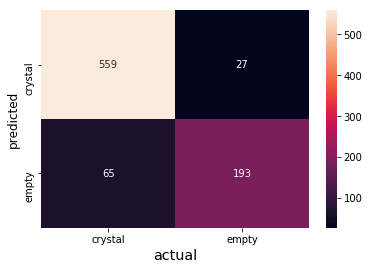

In [11]:
preds_labels = np.where(model.predict_generator(test_generator) < 0.5, 'crystal', 'empty')
gt_labels = get_labels_from_generator(test_generator)
axes = plot.plot_confusion_matrix(gt_labels, preds_labels)
axes.get_figure().savefig('confusion_matrix.png')

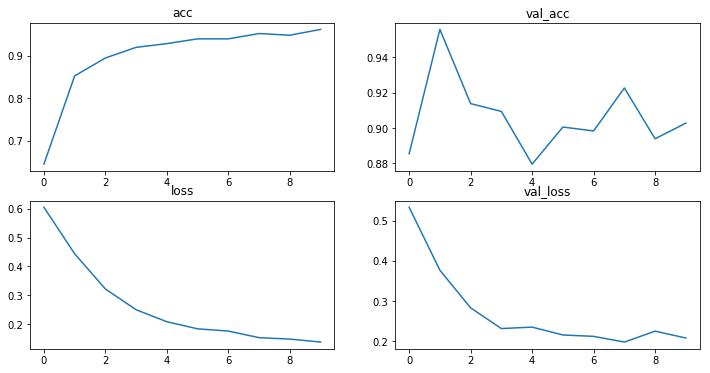

In [154]:
plot.plot_history(history)

In [128]:
images = np.array(list(chain(*[read_images(d, INPUT_SHAPE) for d in (DATA_DIR / 'test').iterdir()]))).reshape((-1, *INPUT_SHAPE))
def predictions_from_images(images, label = None):
    np.random.shuffle(images)
    preds = model.predict(images, batch_size).flatten()
    if label is None:
        labels = np.where(preds < 0.5, 'crystal', 'empty')
    else:
        indices = np.argwhere(preds < 0.5 if label == 'crystal' else preds >= 0.5).ravel()
        labels = np.where(preds[indices] < 0.5, 'crystal', 'empty')
        images = images[indices]
    idx = 0
    for i in range(idx, len(labels), batch_size):
        yield images[idx:idx+batch_size], labels[idx:idx+batch_size]
        idx += batch_size 
preds = predictions_from_images(images)

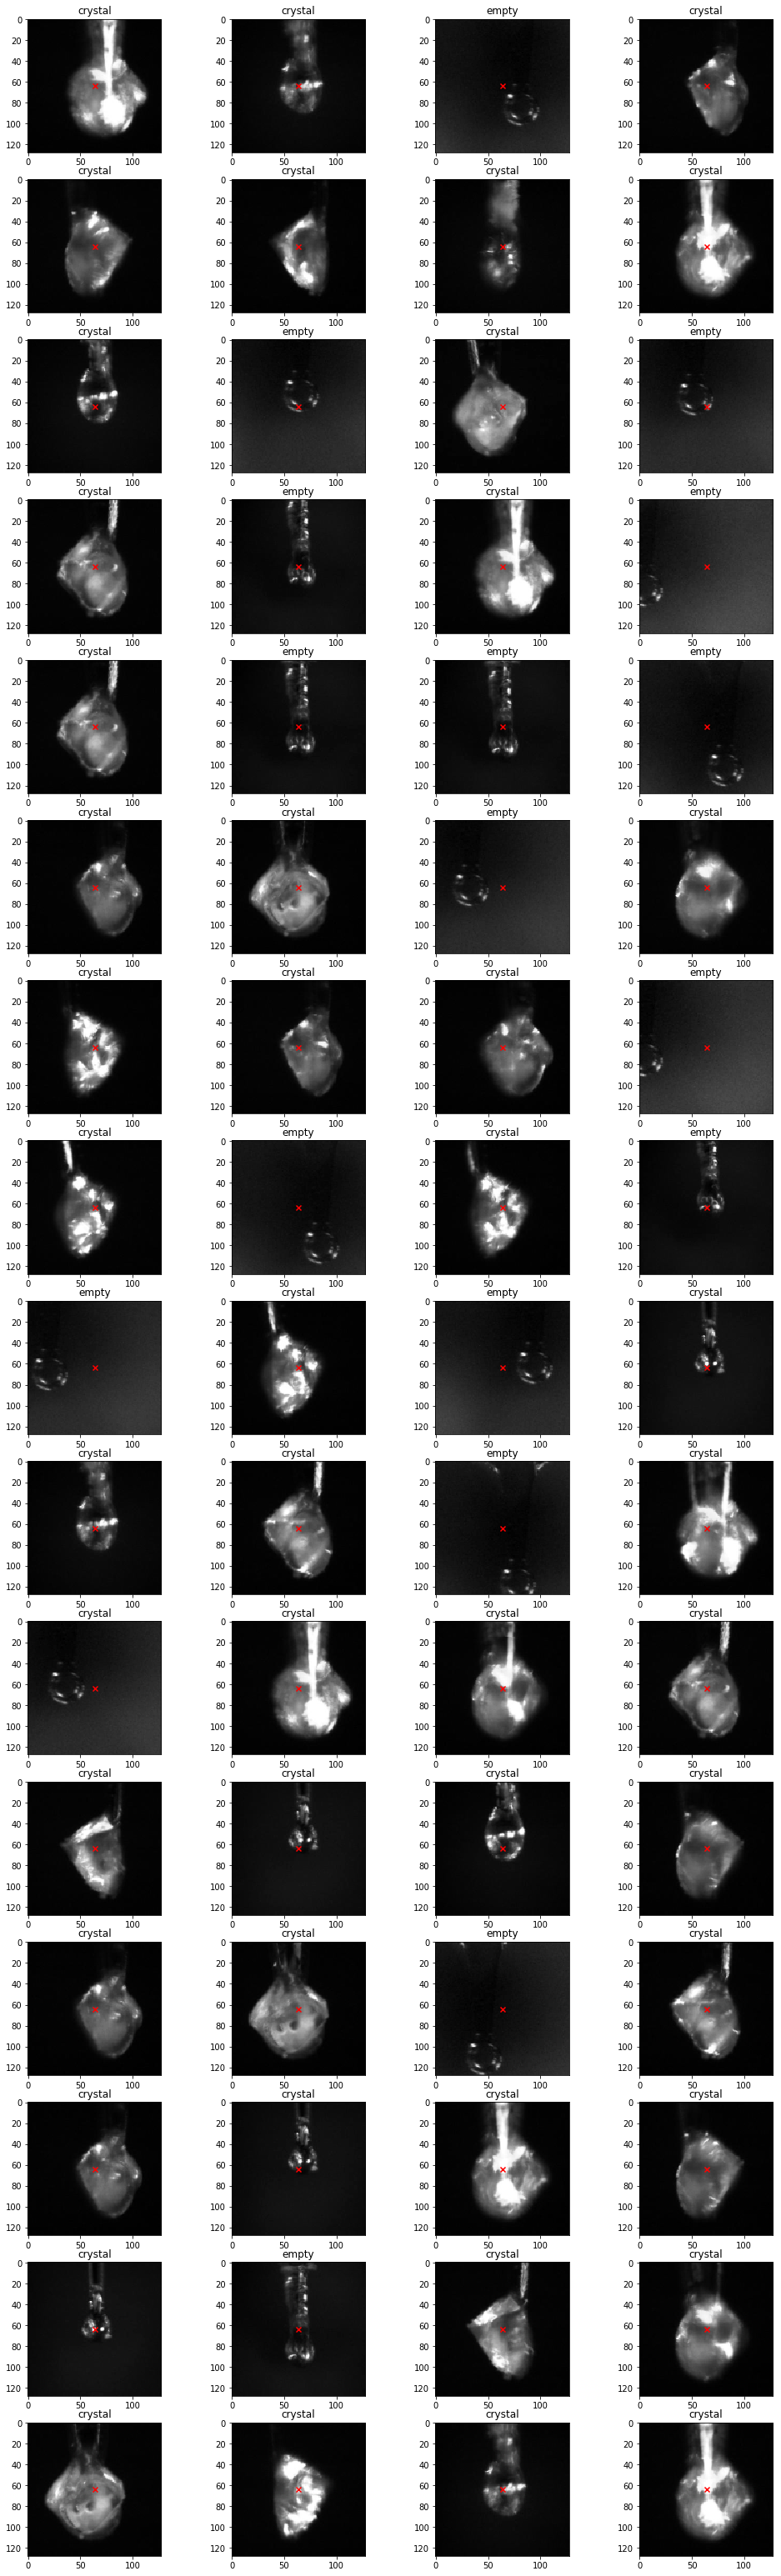

In [129]:
plot.plot_from_generator(preds)

In [4]:
from keras.models import load_model

# model.save('final_class.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('final_class.h5')

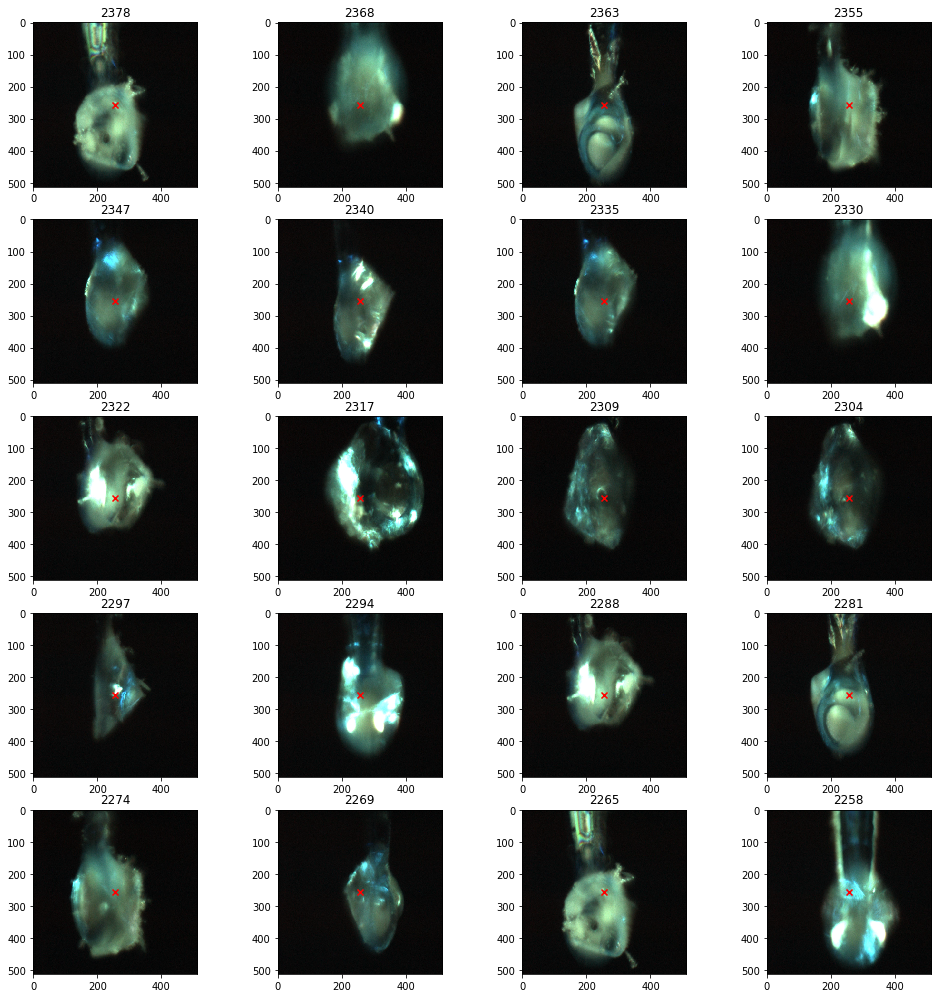

In [63]:
m: pd.DataFrame = pd.read_csv('/data/staff/common/ML-crystals/csv/harvest2_0.5.csv')
m = m.sort_values('y', ascending=False)
indices = m.index[160::21]
m = m.loc[indices][:20]
# m = m.sample(n=10)
images = [read_image(fp, (512, 512, 3)) for fp in m['filename']]
titles = m['y']
plot.image_grid(images, titles);